In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

# ==== USER INPUTS ====
csv_path = Path('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv')
outdir = Path('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war')
target_col = 'natural_forest_loss (h)'
year_col = "Year"
# ======================

outdir.mkdir(exist_ok=True)

# Load data
df = pd.read_csv(csv_path)
df[year_col] = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
df = df.dropna(subset=[year_col])
df[year_col] = df[year_col].astype(int)

# Feature selection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = [c for c in numeric_cols if c != target_col and "forest" in c.lower() and "loss" in c.lower()]
feature_cols = [c for c in numeric_cols if c not in exclude_cols + [target_col]]

# Train/test split
train = df[df[year_col] <= 2018].dropna(subset=[target_col])
test  = df[df[year_col] > 2018]

X_train, y_train = train[feature_cols], train[target_col]
X_all = df[feature_cols]

# Ridge regression pipeline
alphas = np.logspace(-3, 4, 20)
tscv = TimeSeriesSplit(n_splits=min(5, max(2, len(train)//3)))
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=alphas, cv=tscv))
])
pipe.fit(X_train, y_train)

# Predictions & impact
df["pred_counterfactual"] = pipe.predict(X_all)
df["impact"] = np.where(df[year_col] > 2018, df[target_col] - df["pred_counterfactual"], np.nan)

# Summary
summary = {
    "alpha": pipe.named_steps["ridge"].alpha_,
    "train_R2": r2_score(y_train, pipe.predict(X_train)),
    "train_RMSE": mean_squared_error(y_train, pipe.predict(X_train)) ** 0.5,
    "total_impact_post2018": df.loc[df[year_col] > 2018, "impact"].sum(),
    "avg_annual_impact_post2018": df.loc[df[year_col] > 2018, "impact"].mean()
}

# ==== PRINT RESULTS BEFORE SAVING ====
print("\n=== Model Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")
print("\n=== First few rows of predictions ===")
print(df[[year_col, target_col, "pred_counterfactual", "impact"]])
print("\n=== Post-2018 Impact by Year ===")
print(df.loc[df[year_col] > 2018, [year_col, "impact"]])

# Save results
df.to_csv(outdir / "ridge_counterfactual_predictions.csv", index=False)
pd.DataFrame([summary]).to_csv(outdir / "ridge_impact_summary.csv", index=False)

# Plot actual vs counterfactual (in millions)
plt.figure(figsize=(10,6))
plt.plot(df[year_col], df[target_col] / 1e6, marker="o", label="Actual")
plt.plot(df[year_col], df["pred_counterfactual"] / 1e6, marker="o", linestyle="--", label="Counterfactual")
plt.axvline(2018.5, color="black", linestyle="--")
# plt.axvspan(df[year_col].min()-0.5, 2018.5, color="lightgray", alpha=0.3, label="Train")
# plt.axvspan(2018.5, df[year_col].max()+0.5, color="mistyrose", alpha=0.3, label="Post")
plt.xlabel("Year")
plt.ylabel("Natural Forest Loss (million ha)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig(outdir / "ridge_actual_vs_counterfactual.png")
plt.show()
plt.close()

# Plot impact bars (in millions)
post = df[df[year_col] > 2018]
plt.figure(figsize=(8,5))
plt.bar(post[year_col], post["impact"] / 1e6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Excess Loss (million ha)")
plt.tight_layout()
plt.savefig(outdir / "ridge_impact_bar.png")
plt.show()
plt.close()

print(f"Done. Outputs saved in: {outdir}")

In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# ==== USER INPUTS ====
csv_path = Path('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv')
outdir = Path('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war')
target_col = 'natural_forest_loss (h)'
year_col = "Year"

# Columns likely contaminated by tariff (optional)
contaminated_keywords = ["soy", "export", "china", "production"]
# ======================

outdir.mkdir(exist_ok=True)

# Load data
df = pd.read_csv(csv_path)
df[year_col] = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
df = df.dropna(subset=[year_col]).copy()
df[year_col] = df[year_col].astype(int)



In [20]:
df.columns

Index(['Unnamed: 0', 'Year', 'Hurs', 'pr', 'tas', 'exchange_rate',
       'Trade_value_brazil_china', 'soy_production(ton)',
       'Soybean_production(h)', 'Export_Usa_china_MT', 'forest_loss_PA (h)',
       'forest_loss_SC (h)', 'natural_forest_loss (h)',
       'non_natural_forest_loss (h)', 'soy_production(MT)'],
      dtype='object')


=== Model Summary (XGBoost) ===
train_R2: 0.9999760434114356
train_RMSE: 3492.0741148418047
total_impact_post2018: 6597612.452857606
avg_annual_impact_post2018: 1099602.0754762676

=== Predictions & Impacts ===
    Year  natural_forest_loss (h)  pred_counterfactual        impact
0   2001                      NaN         4.949117e+05           NaN
1   2002             5.920312e+05         5.942404e+05           NaN
2   2003             5.413787e+05         5.419412e+05           NaN
3   2004             6.954028e+05         6.884728e+05           NaN
4   2005             6.365808e+05         6.352945e+05           NaN
5   2006             6.114023e+05         6.125739e+05           NaN
6   2007             6.692643e+05         6.674806e+05           NaN
7   2008             6.109409e+05         6.115924e+05           NaN
8   2009             5.039815e+05         5.102523e+05           NaN
9   2010             7.346627e+05         7.321372e+05           NaN
10  2011             4.739571

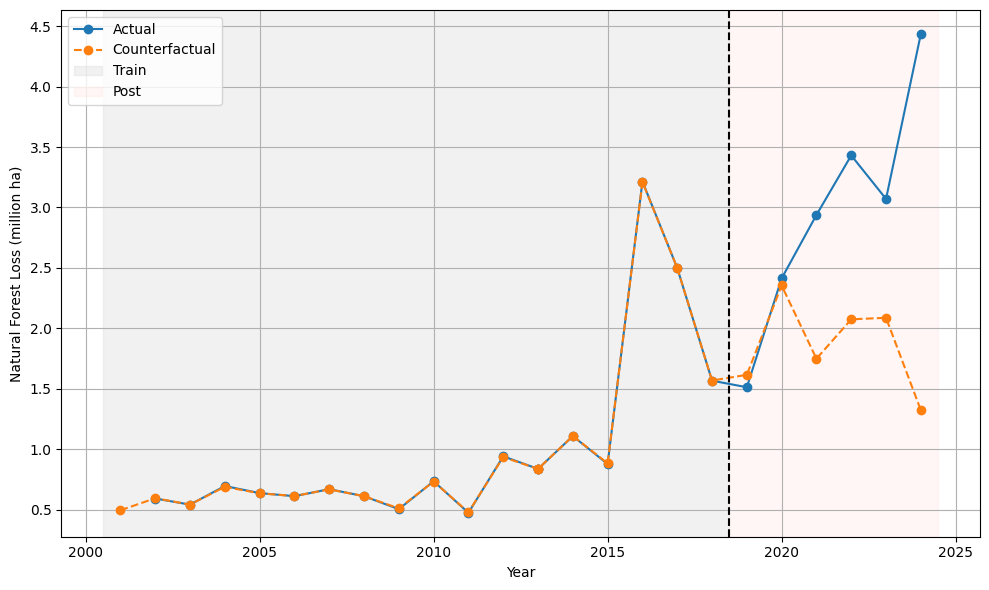

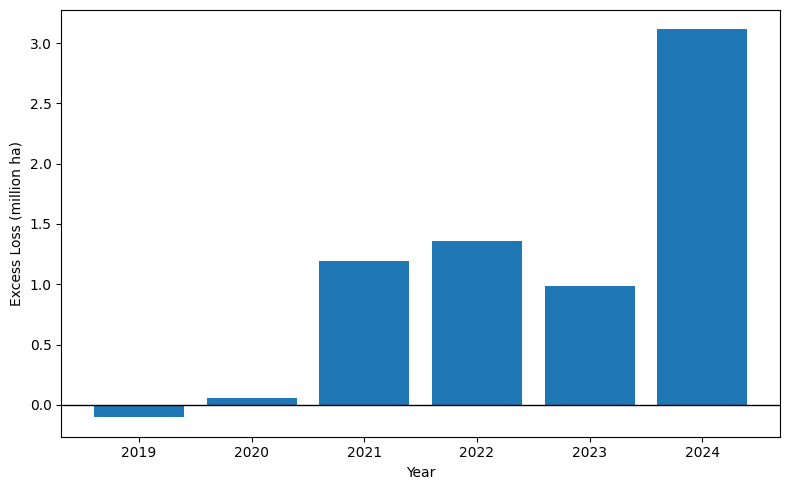


Done. Outputs saved in: /Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war


In [21]:
# Feature selection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = ['Hurs', 'pr', 'tas', 'exchange_rate',
       'Trade_value_brazil_china', 'soy_production(ton)',
       'Soybean_production(h)', 'Export_Usa_china_MT']

# Train/test split
train = df[df[year_col] <= 2018].dropna(subset=[target_col])
X_train, y_train = train[feature_cols], train[target_col]
X_all = df[feature_cols]

# Impute missing
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_all_imp = imp.transform(X_all)

# XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_imp, y_train)

# Predictions & impact
df["pred_counterfactual"] = model.predict(X_all_imp)
df["impact"] = np.where(df[year_col] > 2018, df[target_col] - df["pred_counterfactual"], np.nan)

# Summary
train_pred = model.predict(X_train_imp)
summary = {
    "train_R2": r2_score(y_train, train_pred),
    "train_RMSE": mean_squared_error(y_train, train_pred) ** 0.5,
    "total_impact_post2018": df.loc[df[year_col] > 2018, "impact"].sum(),
    "avg_annual_impact_post2018": df.loc[df[year_col] > 2018, "impact"].mean()
}

# Print results
print("\n=== Model Summary (XGBoost) ===")
for k, v in summary.items():
    print(f"{k}: {v}")
print("\n=== Predictions & Impacts ===")
print(df[[year_col, target_col, "pred_counterfactual", "impact"]])

# Save outputs
df.to_csv(outdir / "xgb_counterfactual_predictions.csv", index=False)
pd.DataFrame([summary]).to_csv(outdir / "xgb_impact_summary.csv", index=False)

# Plot actual vs counterfactual
plt.figure(figsize=(10,6))
plt.plot(df[year_col], df[target_col]/1e6, marker="o", label="Actual")
plt.plot(df[year_col], df["pred_counterfactual"]/1e6, marker="o", linestyle="--", label="Counterfactual")
plt.axvline(2018.5, color="black", linestyle="--")
plt.axvspan(df[year_col].min()-0.5, 2018.5, color="lightgray", alpha=0.3, label="Train")
plt.axvspan(2018.5, df[year_col].max()+0.5, color="mistyrose", alpha=0.3, label="Post")
plt.xlabel("Year")
plt.ylabel("Natural Forest Loss (million ha)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(outdir / "xgb_actual_vs_counterfactual.png")
plt.show()

# Plot impacts
post = df[df[year_col] > 2018]
plt.figure(figsize=(8,5))
plt.bar(post[year_col], post["impact"]/1e6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Excess Loss (million ha)")
plt.tight_layout()
plt.savefig(outdir / "xgb_impact_bar.png")
plt.show()

print(f"\nDone. Outputs saved in: {outdir}")


=== Model Summary (Three-phase) ===
train_R2: 0.9999602149581718
train_RMSE: 495.6257625265874
val_R2: -9.044669877032973
val_RMSE: 352135.53520599543
total_impact_post2018: 14318344.109107606
avg_annual_impact_post2018: 2386390.684851268


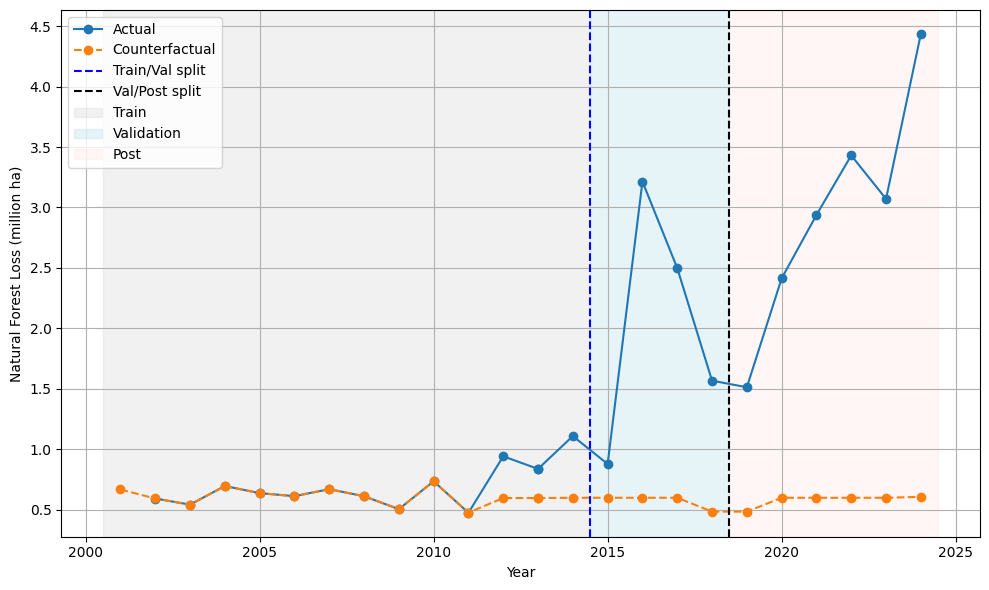

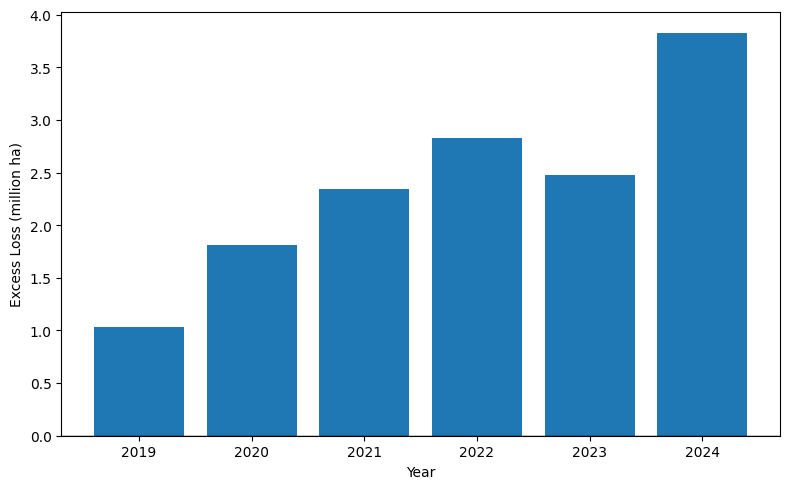


Done. Outputs saved in: /Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war


In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# ==== USER INPUTS ====
csv_path = Path('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv')
outdir = Path('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war')
target_col = 'natural_forest_loss (h)'
year_col = "Year"
feature_cols = [
    'Hurs', 'pr', 'tas', 'exchange_rate',
    'Trade_value_brazil_china', 'soy_production(ton)',
    'Soybean_production(h)', 'Export_Usa_china_MT'
]
# ======================

outdir.mkdir(exist_ok=True)

# Load & clean data
df = pd.read_csv(csv_path)
df[year_col] = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
df = df.dropna(subset=[year_col]).copy()
df[year_col] = df[year_col].astype(int)
for c in feature_cols + [target_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Phase 1: Train (<=2014)
train = df[df[year_col] <= 2011].dropna(subset=[target_col])
X_train, y_train = train[feature_cols], train[target_col]

# Phase 2: Validation (2015–2018)
val = df[(df[year_col] >= 2012) & (df[year_col] <= 2014)].dropna(subset=[target_col])
X_val, y_val = val[feature_cols], val[target_col]

# All data for later full predictions
X_all = df[feature_cols]

# Impute missing
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_val_imp = imp.transform(X_val)
X_all_imp = imp.transform(X_all)

# XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_imp, y_train)

# Predictions
df["pred_counterfactual"] = model.predict(X_all_imp)

# Impacts only for post-2018
df["impact"] = np.where(df[year_col] > 2015, df[target_col] - df["pred_counterfactual"], np.nan)

# Summaries
train_r2 = r2_score(y_train, model.predict(X_train_imp))
train_rmse = mean_squared_error(y_train, model.predict(X_train_imp)) ** 0.5
val_r2 = r2_score(y_val, model.predict(X_val_imp))
val_rmse = mean_squared_error(y_val, model.predict(X_val_imp)) ** 0.5
total_impact = df.loc[df[year_col] > 2018, "impact"].sum()
avg_impact = df.loc[df[year_col] > 2018, "impact"].mean()

summary = {
    "train_R2": train_r2,
    "train_RMSE": train_rmse,
    "val_R2": val_r2,
    "val_RMSE": val_rmse,
    "total_impact_post2018": total_impact,
    "avg_annual_impact_post2018": avg_impact
}

print("\n=== Model Summary (Three-phase) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

# Save outputs
df.to_csv(outdir / "xgb_threephase_predictions.csv", index=False)
pd.DataFrame([summary]).to_csv(outdir / "xgb_threephase_summary.csv", index=False)

# Plot actual vs counterfactual
plt.figure(figsize=(10,6))
plt.plot(df[year_col], df[target_col]/1e6, marker="o", label="Actual")
plt.plot(df[year_col], df["pred_counterfactual"]/1e6, marker="o", linestyle="--", label="Counterfactual")
plt.axvline(2014.5, color="blue", linestyle="--", label="Train/Val split")
plt.axvline(2018.5, color="black", linestyle="--", label="Val/Post split")
plt.axvspan(df[year_col].min()-0.5, 2014.5, color="lightgray", alpha=0.3, label="Train")
plt.axvspan(2014.5, 2018.5, color="lightblue", alpha=0.3, label="Validation")
plt.axvspan(2018.5, df[year_col].max()+0.5, color="mistyrose", alpha=0.3, label="Post")
plt.xlabel("Year")
plt.ylabel("Natural Forest Loss (million ha)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(outdir / "xgb_threephase_actual_vs_counterfactual.png")
plt.show()

# Plot impacts
post = df[df[year_col] > 2018]
plt.figure(figsize=(8,5))
plt.bar(post[year_col], post["impact"]/1e6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Excess Loss (million ha)")
plt.tight_layout()
plt.savefig(outdir / "xgb_threephase_impact_bar.png")
plt.show()

print(f"\nDone. Outputs saved in: {outdir}")